In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import math

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
df = pd.read_csv('./us-counties.csv')

In [4]:
df.columns

Index(['date', 'county', 'state', 'fips', 'cases', 'deaths'], dtype='object')

In [5]:
df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0
3,2020-01-24,Cook,Illinois,17031.0,1,0.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0


In [6]:
ca_df = df[df['state']=='California'].copy()

In [7]:
ca_df.shape

(43895, 6)

In [8]:
ca_df.dtypes

date       object
county     object
state      object
fips      float64
cases       int64
deaths    float64
dtype: object

In [9]:
ca_df['date'] = pd.to_datetime(ca_df['date'])

In [10]:
ca_df = ca_df.groupby(by=['state', 'date'])['cases'].sum()

In [13]:
ca_df = pd.DataFrame(ca_df).reset_index()

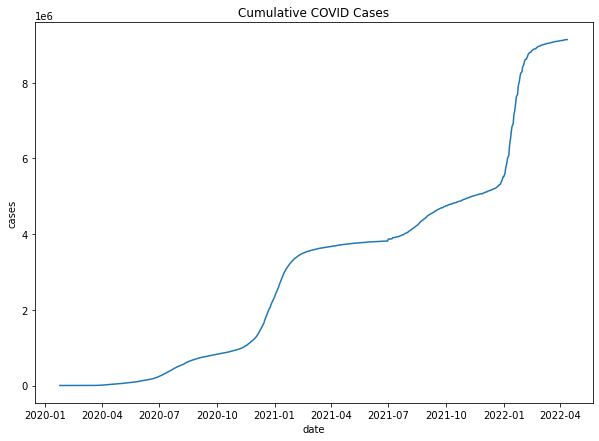

In [14]:
fig, ax = plt.subplots(figsize=(10, 7))

p = sns.lineplot(x='date', y='cases', data=ca_df)
p.set(title="Cumulative COVID Cases")
plt.show()

In [15]:
# assuming 2 week recovery
ca_df['recovered'] = ca_df.sort_values(by='date')['cases'].shift(14)

In [16]:
ca_df['recovered'].fillna(0, inplace=True)

In [17]:
# total california population, 2020
tot_pop = 39538223

In [18]:
ca_df['susceptible'] = tot_pop - ca_df['recovered']

In [19]:
ca_df['infected'] = ca_df['cases'] - ca_df['recovered']

In [20]:
ca_long = ca_df[['date', 'recovered', 'infected', 'susceptible']].melt('date', var_name='status', value_name='num_cases')

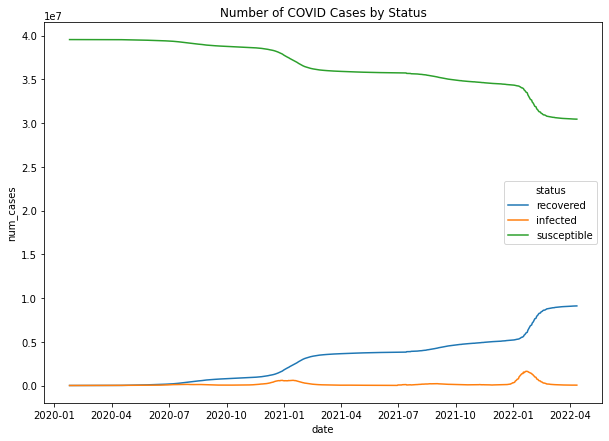

In [21]:
fig, ax = plt.subplots(figsize=(10, 7))

p = sns.lineplot(x='date', y='num_cases', hue='status', data=ca_long)
p.set(title="Number of COVID Cases by Status")
plt.show()

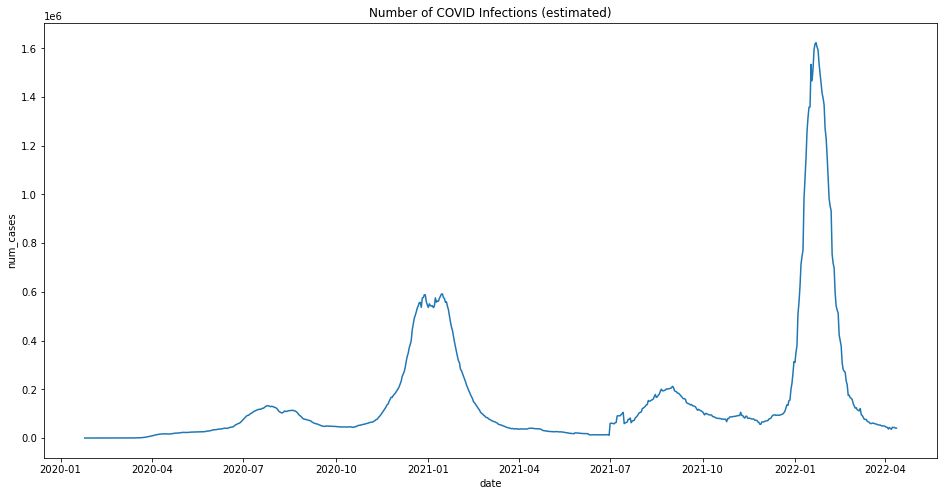

In [22]:
fig, ax = plt.subplots(figsize=(16, 8))

max_y = max(ca_long[ca_long['status']=='infected']['num_cases'])

p = sns.lineplot(x='date', y='num_cases', data=ca_long[ca_long['status']=='infected'])
p.set(title="Number of COVID Infections (estimated)")

plt.show()

In [23]:
ca_infected = ca_df['infected'].values

### Simulation

In [24]:
# Initial number of infections and recovered individuals
I0, R0 = 1, 0

# Total California population (2020 census)
N = tot_pop
N_total = N

# Number of susceptible individuals
S0 = N - R0

# Assume recovery time of 14 days
gamma = 1./14

# Observation timeline
t = np.linspace(0, len(ca_df)-1, len(ca_df))

In [25]:
# initial conditions vector
y0 = S0, I0, R0

#### Time-Dependent R_0


In [26]:
# The SIR model differential equations.
def deriv_dynamic(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta(t) * S * I / N
    dIdt = beta(t) * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [27]:
def R_0_dynamic(t):
    value = None
    for i in range(len(epochs)):
        if t >= epochs[i]:
            value = logistic_R_0(t, k[i], x[i], R_0[i],  R_0[i+1])
    return value

def logistic_R_0(t, k, x, start, end):
    return (start - end) / (1 + np.exp(-k * (-t + x))) + end

def beta_dynamic(t):
    return R_0_dynamic(t) * gamma

In [28]:
def abse(pred, true):
    sum = 0
    for i in range(len(true)):
       sum += abs(true[i] - pred[i]) 
    
    return sum / len(true)

def rmse(pred, true):
    sum = 0
    for i in range(len(true)):
        sum += math.pow(true[i] - pred[i], 2)
    
    return math.sqrt(sum / len(true))

### Minimizing MAE

In [29]:
# Define epoch start dates
epochs = [0, 97, 250, 330, 360, 550, 670, 720]

In [30]:
# R0 values for each epoch
R_0 = [2.5, 1.74, 0.62, 1.77, 0.51, 1.71, 0.89, 2.98, 0.1]

# k and x values for smooth R0 transition function
k = [0.3, 0.07, 0.08, 0.09, 0.1, 0.5, 0.1, 0.38]
x = [60, 175, 265, 343, 480, 576, 690, 727]

In [31]:
ret = odeint(deriv_dynamic, y0, t, args = (N, beta_dynamic, gamma))
S, I, R = ret.T

In [32]:
ca_df['date'].dt.date

0      2020-01-25
1      2020-01-26
2      2020-01-27
3      2020-01-28
4      2020-01-29
          ...    
804    2022-04-08
805    2022-04-09
806    2022-04-10
807    2022-04-11
808    2022-04-12
Name: date, Length: 809, dtype: object

In [33]:
len(I)

809

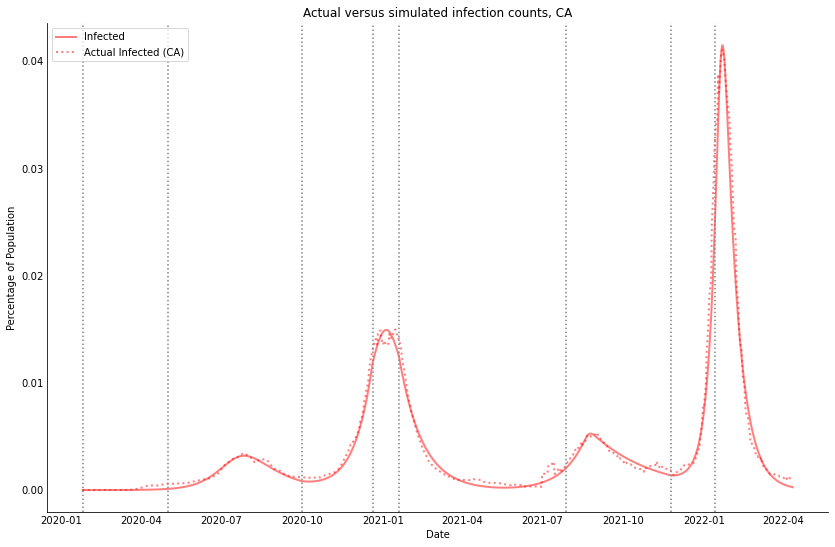

In [35]:
# Plot the data on predicted and actual infections 

fig, ax = plt.subplots(facecolor='w', figsize = (14, 9))

ax.plot(ca_df['date'], I/N_total, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(ca_df['date'], ca_infected/N_total, 'r:', alpha=0.5, lw=2, label='Actual Infected (CA)')
ax.set_xlabel('Date')
ax.set_ylabel('Percentage of Population')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')

for e in epochs:
    date = ca_df['date'].values[e]
    plt.axvline(x=date, color="grey", linestyle=':')
legend = ax.legend()
legend.get_frame().set_alpha(0.75)
for spine in ('top', 'right'):#, 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
    
plt.title("Actual versus simulated infection counts, CA")
plt.show()

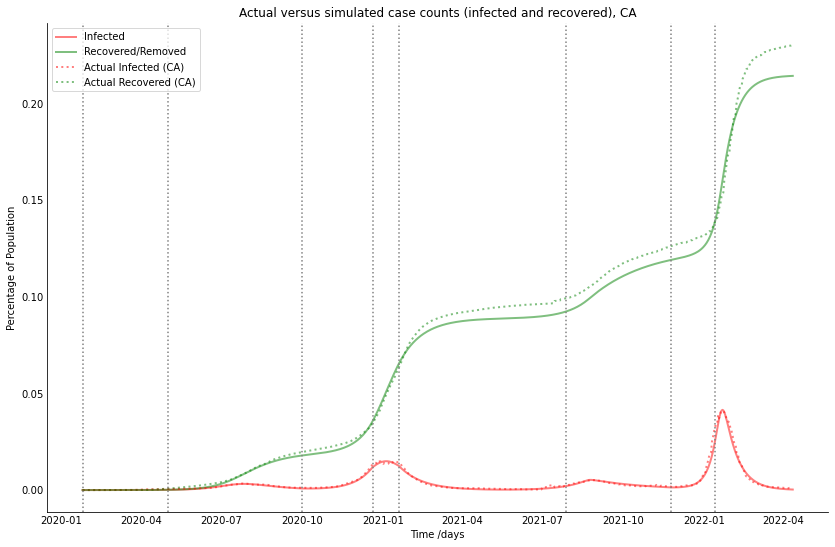

In [36]:
# Plot the data for predicted and actual infections and recoveries

fig, ax = plt.subplots(facecolor='w', figsize = (14, 9))

ax.plot(ca_df['date'], I/N_total, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(ca_df['date'], R/N_total, 'g', alpha=0.5, lw=2, label='Recovered/Removed')
ax.plot(ca_df['date'], ca_infected/N_total, 'r:', alpha=0.5, lw=2, label='Actual Infected (CA)')
ax.plot(ca_df['date'], ca_df['recovered']/N_total, 'g:', alpha=0.5, lw=2, label='Actual Recovered (CA)')
ax.set_xlabel('Time /days')
ax.set_ylabel('Percentage of Population')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')

for e in epochs:
    date = ca_df['date'].values[e]
    plt.axvline(x=date, color="grey", linestyle=':')
legend = ax.legend()
legend.get_frame().set_alpha(0.75)
for spine in ('top', 'right'):#, 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
    
plt.title("Actual versus simulated case counts (infected and recovered), CA")
plt.show()

In [49]:
print(f"Abolute Error: {mean_absolute_error(ca_infected, I)}")

Abolute Error: 19464.637236458086


### Minimizing RMSE

In [37]:
# Define epoch start dates
epochs = [0, 97, 250, 330, 360, 550, 670, 720]

In [38]:
# R0 values for each epoch
R_0 = [2.5, 1.75, 0.6, 1.854, 0.50, 1.73, 0.92, 2.73, 0.1]

# k and x values for smooth R0 transition function
k = [0.3, 0.07, 0.05, 0.09, 0.1, 0.3, 0.1, 0.38]
x = [60, 175, 265, 343, 480, 576, 686, 727]

In [39]:
ret = odeint(deriv_dynamic, y0, t, args = (N, beta_dynamic, gamma))
S, I, R = ret.T

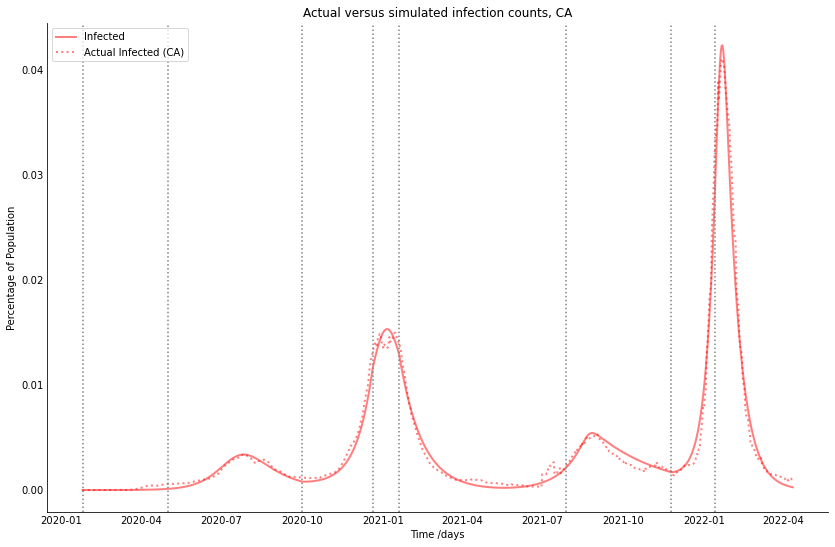

In [41]:
# Plot the data on predicted and actual infections 

fig, ax = plt.subplots(facecolor='w', figsize = (14, 9))

ax.plot(ca_df['date'], I/N_total, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(ca_df['date'], ca_infected/N_total, 'r:', alpha=0.5, lw=2, label='Actual Infected (CA)')
ax.set_xlabel('Time /days')
ax.set_ylabel('Percentage of Population')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')

for e in epochs:
    date = ca_df['date'].values[e]
    plt.axvline(x=date, color="grey", linestyle=':')
legend = ax.legend()
legend.get_frame().set_alpha(0.75)
for spine in ('top', 'right'):#, 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
    
plt.title("Actual versus simulated infection counts, CA")
plt.show()

<ipython-input-42-c33c23f87d27>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ca_df['date'].dt.date)


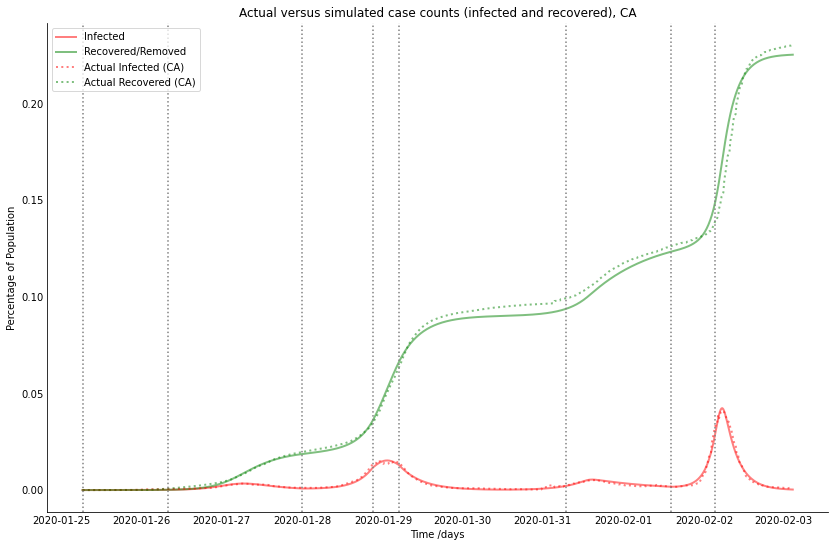

In [42]:
# Plot the data for predicted and actual infections and recoveries

fig, ax = plt.subplots(facecolor='w', figsize = (14, 9))

ax.plot(ca_df['date'], I/N_total, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(ca_df['date'], R/N_total, 'g', alpha=0.5, lw=2, label='Recovered/Removed')
ax.plot(ca_df['date'], ca_infected/N_total, 'r:', alpha=0.5, lw=2, label='Actual Infected (CA)')
ax.plot(ca_df['date'], ca_df['recovered']/N_total, 'g:', alpha=0.5, lw=2, label='Actual Recovered (CA)')
ax.set_xlabel('Time /days')
ax.set_ylabel('Percentage of Population')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
ax.set_xticklabels(ca_df['date'].dt.date)

for e in epochs:
    date = ca_df['date'].values[e]
    plt.axvline(x=date, color="grey", linestyle=':')
legend = ax.legend()
legend.get_frame().set_alpha(0.75)
for spine in ('top', 'right'):#, 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
    
plt.title("Actual versus simulated case counts (infected and recovered), CA")
plt.show()

In [43]:
print(f"RMSE: {mean_squared_error(ca_infected, I, squared=False)}")

RMSE: 31570.996005490415
